In [3]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

# Auxiliary Functions

In [5]:
from baselines.ViT.ViT_LRP import deit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained with DeiT
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to C:\Users\ernan/.cache\torch\hub\checkpoints\deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:35<00:00, 9.87MB/s] 


Top 5 classes:
	243 : bull mastiff    		value = 5.992	 prob = 19.0%
	282 : tiger cat       		value = 5.175	 prob = 8.4%
	285 : Egyptian cat    		value = 4.781	 prob = 5.7%
	281 : tabby, tabby cat		value = 4.690	 prob = 5.2%
	245 : French bulldog  		value = 2.991	 prob = 0.9%


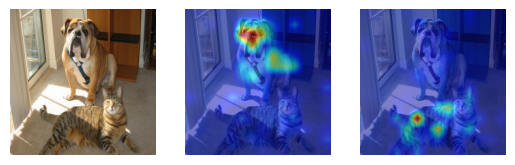

In [6]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# dog 
# generate visualization for class 243: 'bull mastiff' - the predicted class
dog = generate_visualization(dog_cat_image)

# cat - generate visualization for class 282 : 'tiger cat'
cat = generate_visualization(dog_cat_image, class_index=282)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');

Top 5 classes:
	161 : basset, basset hound         		value = 6.327	 prob = 26.5%
	90 : lorikeet                     		value = 4.394	 prob = 3.8%
	88 : macaw                        		value = 4.055	 prob = 2.7%
	166 : Walker hound, Walker foxhound		value = 3.394	 prob = 1.4%
	163 : bloodhound, sleuthhound      		value = 3.352	 prob = 1.4%


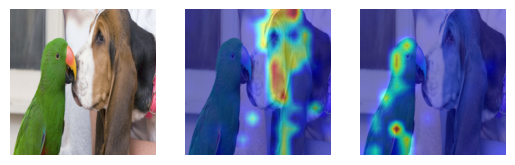

In [7]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 90: 'lorikeet'
parrot = generate_visualization(dog_bird_image, class_index=90)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

Top 5 classes:
	340 : zebra                               		value = 6.759	 prob = 32.7%
	101 : tusker                              		value = 5.557	 prob = 9.8%
	386 : African elephant, Loxodonta africana		value = 5.477	 prob = 9.1%
	385 : Indian elephant, Elephas maximus    		value = 4.774	 prob = 4.5%
	925 : consomme                            		value = 2.237	 prob = 0.4%


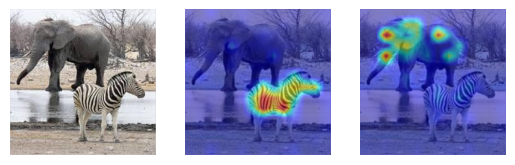

In [8]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# zebra 
# zebra- the predicted class
zebra = generate_visualization(tusker_zebra_image, class_index=340)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization(tusker_zebra_image, class_index=101)

axs[1].imshow(zebra);
axs[1].axis('off');
axs[2].imshow(tusker);
axs[2].axis('off');

Top 5 classes:
	207 : golden retriever  		value = 6.523	 prob = 35.7%
	208 : Labrador retriever		value = 4.288	 prob = 3.8%
	285 : Egyptian cat      		value = 3.641	 prob = 2.0%
	222 : kuvasz            		value = 3.422	 prob = 1.6%
	281 : tabby, tabby cat  		value = 2.778	 prob = 0.8%


(-0.5, 223.5, 223.5, -0.5)

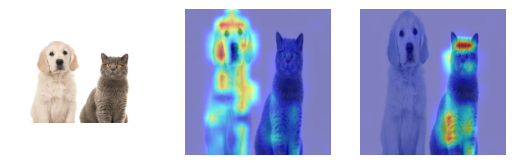

In [10]:
image = Image.open('samples/dogcat2.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# golden retriever - the predicted class
dog = generate_visualization(dog_cat_image)

# generate visualization for class 285: 'Egyptian cat'
cat = generate_visualization(dog_cat_image, class_index=285)


axs[1].imshow(dog)
axs[1].axis('off')
axs[2].imshow(cat)
axs[2].axis('off')